Mapping files: 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Current number of WGS samples: 1550

Current number of variants per WGS sample: 125005

Shape of train data: (1038, 125005)
Shape of train labels: (1038, 1)
Shape of test data: (512, 125005)
Shape of test labels: (512, 1)
Creating model...
Creating model... DONE
Training model...
Epoch 1/20
23/23 [==============================] - 8s 125ms/step - loss: 2.0589 - accuracy: 0.4634 - auc: 0.4951 - val_loss: 15.6122 - val_accuracy: 0.3654 - val_auc: 0.5000

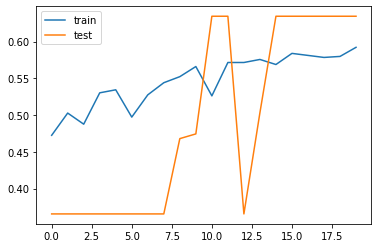

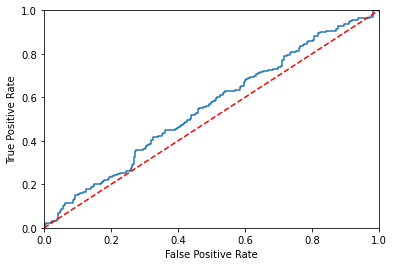

In [1]:
from pandas_plink import read_plink
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import EarlyStopping

from read_data import *
from train_data import *
from utils import *

diagnostic_dict = read_diagnose(file_path='../diagnosis_data/DXSUM_PDXCONV_ADNIALL.csv')

(bim, fam, bed) = read_plink('../wgs_data/clean')

# bed:
#   0 -> First allele
#   1 -> Heterozygous
#   2 -> Second allele
#   math.nan -> missing genotype

n_wgs_samples = bed.shape[1]
n_SNPs = bed.shape[0]

print(f"Current number of WGS samples: {n_wgs_samples}\n")
print(f"Current number of variants per WGS sample: {n_SNPs}\n")

# Generate dataset from input data
x, y = generate_dataset(diagnostic_dict, fam, bed)
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True)
print(f"Shape of train data: {x_train.shape}")
print(f"Shape of train labels: {y_train.shape}")

print(f"Shape of test data: {x_test.shape}")
print(f"Shape of test labels: {y_test.shape}")
# print(y_test)

# Create and fit model
print("Creating model...")
model = create_MLP_model(n_SNPs)
print("Creating model... DONE")

print("Training model...")
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=100, verbose=1)
history = model.fit(x_train, y_train, epochs=20, validation_split=0.3, callbacks=[es])  # validation_split=0.3
print("Training model... DONE")

plot_training_history(history)

print("Evaluate model...")
model.evaluate(x_test, y_test, verbose=2)

y_test_prob = model.predict(x_test)


fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plot_roc_curve(fpr, tpr)

auc_score = roc_auc_score(y_test, y_test_prob)